# Expore data

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np

# definition
path_save_df_feat = "data/path_save_df_feat.csv"

## Load raw features

In [2]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw



,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18643,1676574000000,1716.68,1718.19,1706.83,1710.85,15820.92910,2023-02-16 19:00:00,1566.897500,1527.800000,1660.235,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18644,1676577600000,1710.85,1711.11,1680.00,1685.00,48306.90610,2023-02-16 20:00:00,1570.302500,1529.095000,1665.695,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18645,1676581200000,1684.99,1685.00,1667.54,1683.09,29334.82390,2023-02-16 21:00:00,1588.770000,1545.625000,1683.610,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
18646,1676584800000,1683.09,1684.89,1641.40,1646.09,43934.43760,2023-02-16 22:00:00,1617.352500,1571.110000,1692.185,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [3]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
rsi_h_BTC                  13
min_low_h_ETH              13
min_low_h_BTC              13
chop_h_BTC                 13
rsi_h_ETH                  13
max_high_h_ETH             13
max_high_h_BTC             13
chop_h_ETH                 13
ichi_cloud_a_BTC           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_ETH           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
rsi_d_ETH                 335
min_low_d_BTC             335
max_high_d_BTC            335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
chop_d_ETH                335
chop_d_BTC                335
ichi_cloud_a_day_ETH      623
ichi_cloud_a_day_BTC      623
ichi_kijun_day_ETH        623
ichi_kijun_day_BTC        623
dxy                      1109
fvx                      1117
spx                     

<AxesSubplot: >

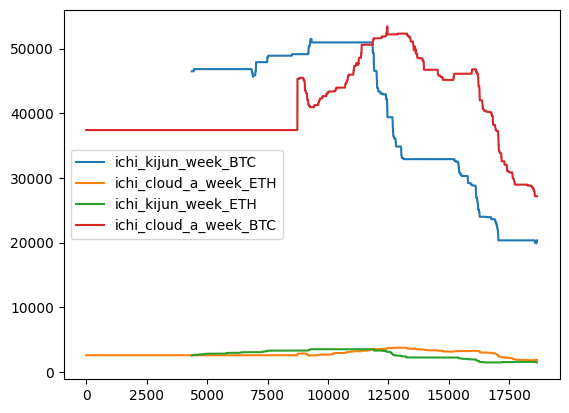

In [4]:
df_feat_raw[["ichi_kijun_week_BTC"   ,    
"ichi_cloud_a_week_ETH"   ,  
"ichi_kijun_week_ETH"    ,   
"ichi_cloud_a_week_BTC"]].plot()

In [5]:
print(df_feat_raw.shape)
df_feat = df_feat_raw.dropna(subset=["ichi_kijun_week_ETH"])
df_feat.shape

(18648, 135)


(14281, 135)

In [6]:
nb_missing = get_missing(df_feat)
nb_missing

missing data : 
Consensus_num       14210
delta_event_real    14210
delta_event_pred    14210
Previous_num        14210
Actual_num          14210
Event               14210
Date                14210
Previous            14210
Consensus           14210
Actual              14210
Country             14210
Time (ET)           14210
keep                14210
date                14210
dtype: int64

on 14281 samples


Consensus_num       14210
delta_event_real    14210
delta_event_pred    14210
Previous_num        14210
Actual_num          14210
Event               14210
Date                14210
Previous            14210
Consensus           14210
Actual              14210
Country             14210
Time (ET)           14210
keep                14210
date                14210
dtype: int64

In [7]:
4367/24

181.95833333333334

## Normalisation

### Price dependent

In [8]:
list_col = df_feat_raw.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [9]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [10]:
df_feat_raw[list_col_ETH]

,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,...,vwap_m_ETH,vwap_3m_ETH,vwap_6m_ETH,vwap_y_ETH,vwap_all_ETH,vwap_z_score_ETH,nupl_ETH,supply_ETH,act_addr_ETH,market_dom_ETH
0,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2324.747451,2317.021738,NaN,NaN,...,734.133333,734.133333,734.133333,734.133333,734.133333,NaN,-0.000086,1.140938e+08,445278.0,10.804230
1,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2324.747451,2317.021738,NaN,NaN,...,740.273102,740.273102,740.273102,740.273102,740.273102,0.796866,0.010700,1.140938e+08,445278.0,10.804230
2,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2324.747451,2317.021738,NaN,NaN,...,741.682885,741.682885,741.682885,741.682885,741.682885,0.325738,0.003195,1.140938e+08,445278.0,10.804230
3,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2324.747451,2317.021738,NaN,NaN,...,742.135753,742.135753,742.135753,742.135753,742.135753,0.439488,0.003604,1.140938e+08,445278.0,10.804230
4,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2324.747451,2317.021738,NaN,NaN,...,742.230872,742.230872,742.230872,742.230872,742.230872,0.011168,0.000080,1.140938e+08,445278.0,10.804230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18643,1716.68,1718.19,1706.83,1710.85,15820.92910,2023-02-16 19:00:00,1566.897500,1527.800000,1660.235,1704.105,...,1481.423425,2192.241093,2112.034508,1684.967117,2112.034508,-0.408219,-0.234494,1.204963e+08,434425.0,18.136519
18644,1710.85,1711.11,1680.00,1685.00,48306.90610,2023-02-16 20:00:00,1570.302500,1529.095000,1665.695,1704.105,...,1481.436143,2192.149994,2112.000771,1684.877674,2112.000771,-0.434494,-0.253413,1.204963e+08,434425.0,18.136519
18645,1684.99,1685.00,1667.54,1683.09,29334.82390,2023-02-16 21:00:00,1588.770000,1545.625000,1683.610,1704.105,...,1481.464607,2192.067967,2111.979628,1684.831222,2111.979628,-0.436423,-0.254823,1.204963e+08,434425.0,18.136519
18646,1683.09,1684.89,1641.40,1646.09,43934.43760,2023-02-16 22:00:00,1617.352500,1571.110000,1692.185,1692.185,...,1481.493730,2191.971223,2111.946426,1684.796788,2111.946426,-0.474046,-0.283008,1.204963e+08,434425.0,18.136519


In [11]:
list_price_dep_ETH = [
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    "Close_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH'
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]




In [12]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [13]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'atr_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [14]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [15]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

## Non dependant of price

In [16]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'ichi_tenkan_week_ETH',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'max_high_h_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekda

## Features preparation

In [17]:
df_feat_raw.shape[0]

18648

In [18]:
TRAIN_SPLIT = round(0.8*df_feat_raw.shape[0])
TRAIN_SPLIT

14918

In [19]:
df_feat_raw["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_raw.shape[0])]
df_feat_raw

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,2324.747451,2317.021738,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18643,1676574000000,1716.68,1718.19,1706.83,1710.85,15820.92910,2023-02-16 19:00:00,1566.897500,1527.800000,1660.235,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
18644,1676577600000,1710.85,1711.11,1680.00,1685.00,48306.90610,2023-02-16 20:00:00,1570.302500,1529.095000,1665.695,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
18645,1676581200000,1684.99,1685.00,1667.54,1683.09,29334.82390,2023-02-16 21:00:00,1588.770000,1545.625000,1683.610,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
18646,1676584800000,1683.09,1684.89,1641.40,1646.09,43934.43760,2023-02-16 22:00:00,1617.352500,1571.110000,1692.185,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [94]:
def gen_sequence(id_df, seq_length, seq_cols, i_price_dep):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        out_matrix = data_matrix[start:stop, :].copy()

        out_matrix[:, i_price_dep] = (
            out_matrix[:, i_price_dep] / out_matrix[-1, 0]
        )
        yield out_matrix

def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [97]:
list_col_select = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    "day_off"
]

"""i_col_price_dep = [
    (col != "Close_ETH") 
    and 
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]"""

i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]
i_col_price_dep

[True, True, True, True, False]

In [98]:
df_feat_raw[list_col_select]

,Close_ETH,Open_ETH,High_ETH,Low_ETH,day_off
0,734.07,736.42,739.00,729.33,0.0
1,748.28,734.08,749.00,733.37,0.0
2,744.06,748.27,749.00,742.27,0.0
3,744.82,744.06,747.23,743.10,0.0
4,742.29,744.87,747.09,739.30,0.0
...,...,...,...,...,...
18643,1710.85,1716.68,1718.19,1706.83,0.0
18644,1685.00,1710.85,1711.11,1680.00,0.0
18645,1683.09,1684.99,1685.00,1667.54,0.0
18646,1646.09,1683.09,1684.89,1641.40,0.0


In [99]:
sequence_length = 48

X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat_raw.groupby("train"):

    for seq in gen_sequence(_df, sequence_length, list_col_select, i_col_price_dep):

        if is_train:
            X_train.append(seq)
        else:
            X_test.append(seq)
    
    for seq_y in gen_labels(_df, sequence_length, ['Close_ETH']):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14871, 48, 5) (14871, 1)
(3681, 48, 5) (3681, 1)


In [100]:
seq

array([[1.08116695, 1.09113449, 1.09330866, 1.0794164 , 0.        ],
       [1.06303848, 1.08116695, 1.08129154, 1.05616711, 0.        ],
       [1.06749896, 1.06302602, 1.07018396, 1.05469066, 0.        ],
       [1.07716747, 1.06749896, 1.07764093, 1.0610512 , 0.        ],
       [1.07701173, 1.07716747, 1.08008298, 1.07032102, 0.        ],
       [1.07542315, 1.07701173, 1.07820784, 1.07147351, 0.        ],
       [1.07395294, 1.07541692, 1.07845702, 1.07156696, 0.        ],
       [1.06932426, 1.07395917, 1.07395917, 1.0614063 , 0.        ],
       [1.0628329 , 1.06933049, 1.06985379, 1.06004199, 0.        ],
       [1.06924951, 1.0628329 , 1.06971051, 1.06112596, 0.        ],
       [1.05145744, 1.06924951, 1.07045807, 1.04353947, 0.        ],
       [1.05639761, 1.05145744, 1.05905146, 1.04971312, 0.        ],
       [1.06444017, 1.05639761, 1.06480772, 1.04659826, 0.        ],
       [1.06909376, 1.0644464 , 1.06923082, 1.06026626, 0.        ],
       [1.06791635, 1.06909376, 1.

In [101]:
y_train

array([[ 775.81],
       [ 776.97],
       [ 778.94],
       ...,
       [1605.39],
       [1605.21],
       [1602.13]])